# DustyPY: Comprehensive Tutorial

This notebook demonstrates the standard workflow of **DustyPY**, a modern Python wrapper for the **dusty** radiative transfer code. We will cover model definition, automated data retrieval from **VizieR**, simulation execution, and MCMC parameter estimation.

**1. Imports and Configuration**

First, we import the core classes. We also configure the environment to ensure efficient parallel processing during MCMC sampling.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dustypy import Model, Runner, Dataset, Fitter, Result, Filter, utils

# Configuration optionnelle pour des plots propres
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

**2. Defining the Physical Model**

The `Model` class is the central repository for your system's parameters, including stars, dust properties, and geometry.

In [2]:
# Initialize a model for a Red Supergiant (e.g., Betelgeuse)
# We define the model name and the system distance in parsecs
model = Model(name="Betelgeuse_Fit", distance=222.0)

# Add the central star: Temperature (K), Luminosity (L_sun), and surface gravity (logg)
# Note: luminosity is absolute, DustyPY handles de-normalization internally
model.add_star(temperature=3600, luminosity=1.2e5, logg=-0.5)

# Configure dust envelope and geometry
model.set_dust(
    opacity=0.15,          # Optical depth (tau_V) at 0.55 microns
    temperature=450,       # Inner dust temperature boundary (K)
    envelope_type='POWD',  # Density profile: Power-law (POWD) or Radiatively Driven Winds (RDW)
    thickness=1000.0       # Relative envelope thickness (Y = R_out / R_in)
)

print(model)

<Model(name='Betelgeuse_Fit', distance=222.0pc, stars=1, L_tot=1.20e+05L_sun)>


**3. Retrieving Observational Data**

We use the `Dataset` class to fetch a Spectral Energy Distribution (SED) directly from VizieR.

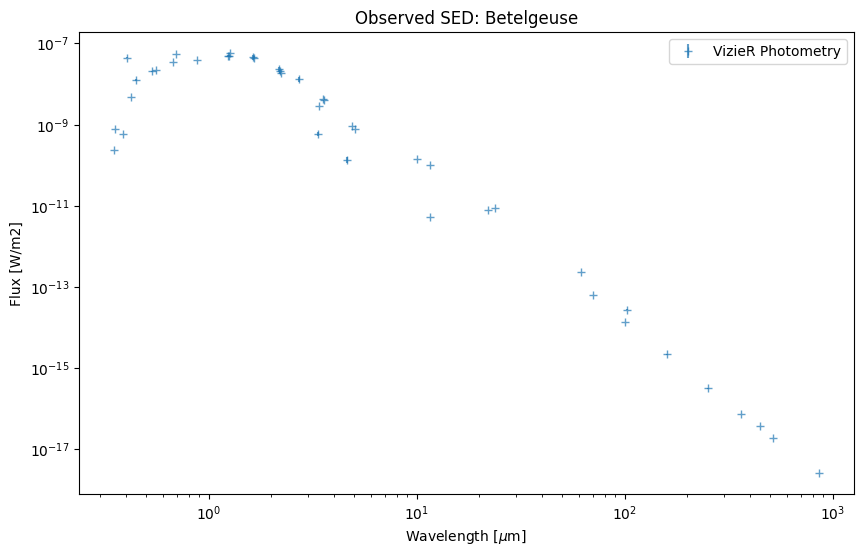

In [3]:
# Fetch Betelgeuse data from VizieR SED service
# aggregate=True merges multiple observations within the same filter bandpass
dataset = Dataset.from_vizier("HD39801", radius_arcsec=5.0, aggregate=True)

# Visualize the raw data
dataset.plot(label="VizieR Photometry", alpha=0.7)
plt.title("Observed SED: Betelgeuse")
plt.legend()
plt.show()

you can of course restrict data as follow:

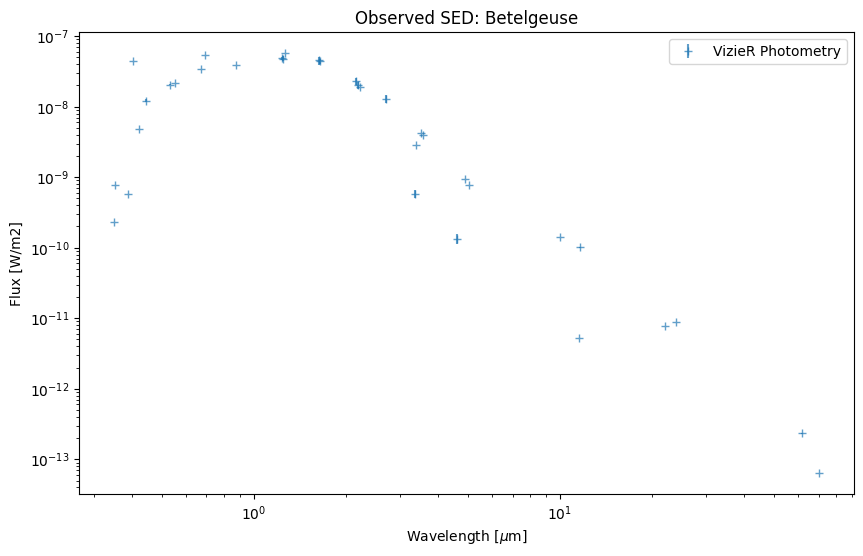

In [ ]:
dataset.restrict(condition='wavelength <= 100')  # in microns
dataset.restrict(condition='eflux > 0')  # positive errors only

# Visualize the raw data
dataset.plot(label="VizieR Photometry", alpha=0.7)
plt.title("Observed SED: Betelgeuse")
plt.legend()
plt.show()

You can also unred you're data using `dataset.apply_extinction_correction()`:

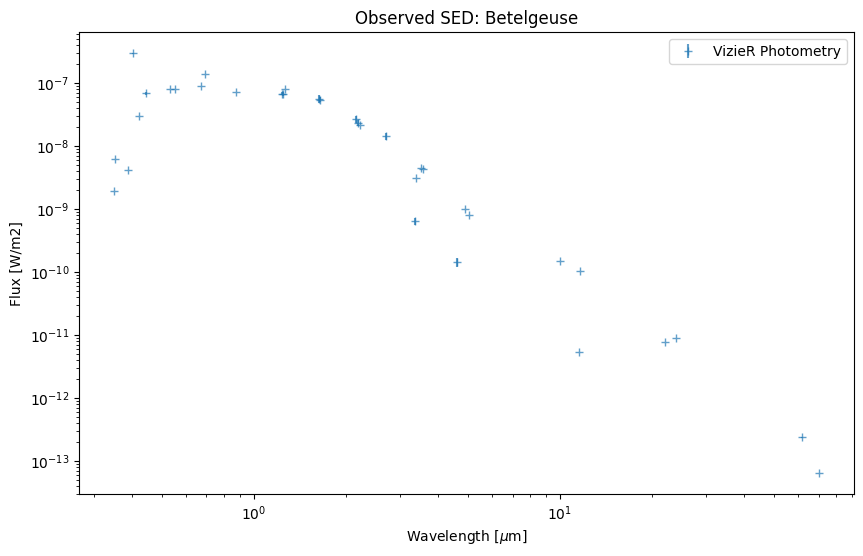

In [5]:
dataset.apply_extinction_correction(ebv=0.470, rv=3.1)

# Visualize the raw data
dataset.plot(label="VizieR Photometry", alpha=0.7)
plt.title("Observed SED: Betelgeuse")
plt.legend()
plt.show()

**4. Running the Simulation**

The `Runner` class handles the Dusty binary execution. It isolates runs in temporary directories to prevent file collisions during parallel tasks.


                             DustyPY Result: Betelgeuse_Fit                            
  System Parameters:
    Wavelength Range              : 3.489e-01 to 1.000e+03 μm
    Total Luminosity              : 1.200e+05 L_sun
    Distance                      : 222.00 pc
    True Radius (r1)              : 2.203e+13 m
    Optical Depth (tau0)          : 1.500e-01
    Inner Dust Temperature        : 4.500e+02
    Outer Dust Temperature        : 3.260e+01



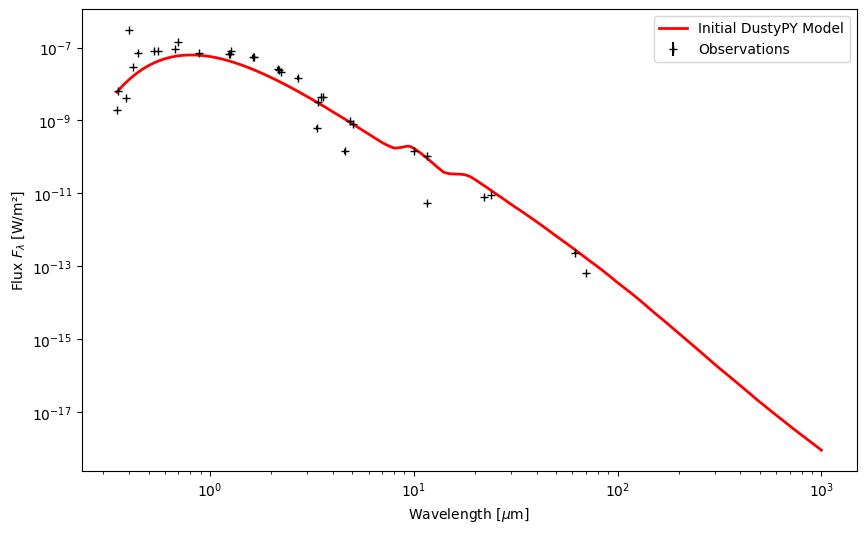

In [ ]:
BINPATH = "PATH/TO/DUSTY/EXECUTABLE"   # Path to Dusty executable

# Initialize the Runner with the path to your Dusty executable
runner = Runner(binary_path=BINPATH)

# Execute the simulation
# Returns a Result object with physical SI units (W/m²)
run_dir = "tmp_run"  # Directory to store temporary run files

result = runner.run(model, run_dir=run_dir)

# Display a detailed summary: Physical radii, mass-loss rate, and synthetic photometry
print(result)

# Quick visualization: Model vs. Data
ax = dataset.plot(label="Observations", color='black', ls='')
result.plot(ax=ax, label="Initial DustyPY Model", color='red', lw=2)
plt.show()

**5. Automated MCMC Fitting**

The `Fitter` class couples DustyPY with the `PyMCMC` library to find the best physical parameters.

In [7]:
# Link the dataset to the model for likelihood calculation
model.set_dataset(dataset)

# Initialize the Fitter (using n_workers > 1 for parallel processing)
fitter = Fitter(model, runner, dataset, n_workers=4)

# Define free parameters with their initial values and search bounds
fitter.add_star_parameter(0, 'temp', initial=3600, min_val=3000, max_val=4200)
fitter.add_parameter('opacity', initial=0.15, min_val=0.01, max_val=1.0)
fitter.add_parameter('thickness', initial=1000, min_val=10, max_val=5000)

# Run the MCMC sampler (using Delayed Rejection Adaptive Metropolis)
# A progress bar will track the iterations
# Total number of iteration is n_iterations*n_workers
analyzer = fitter.run(n_iterations=100, progress=True)

Parallel MCMC Sampling: 100%|██████████| 400/400 [02:37<00:00,  2.54it/s]


Automatic Burn-in detected: 50.0%
Convergence Diagnostic (R-hat): [1.49653064 1.02813053 2.2992459 ]


**6. Analyzing Results**

After sampling, we can inspect the parameter convergence and the best-fit model.

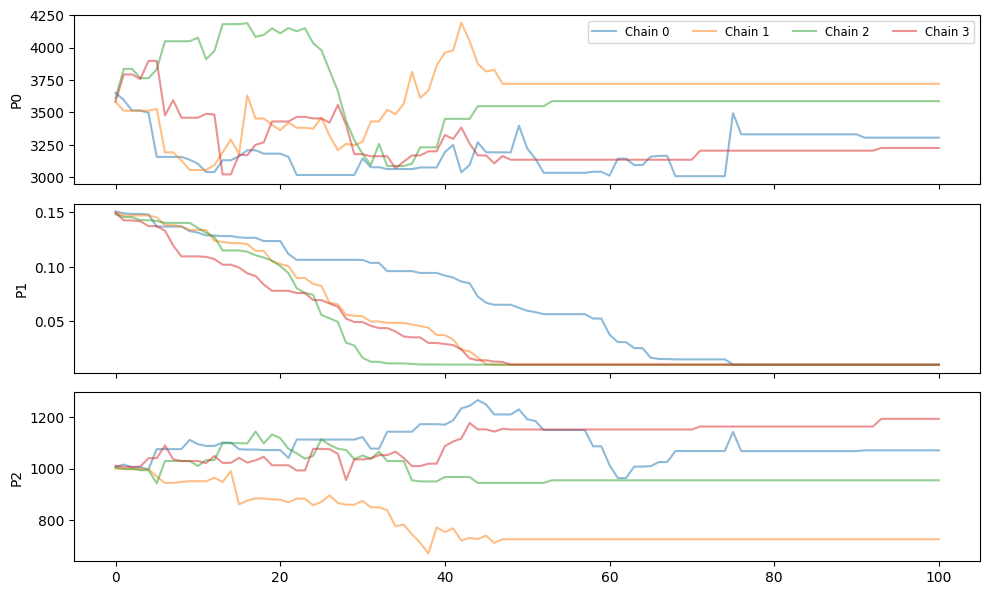

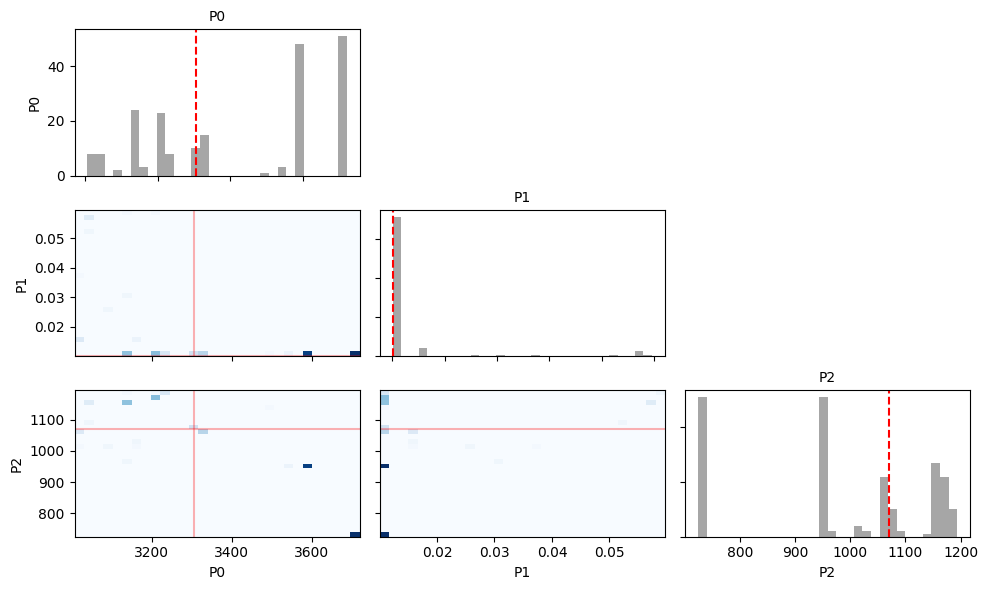

/Users/gtomassini/Documents/Git_Repo/DustyPY/src/dustypy/core/dataset.py:256: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "+" (-> marker='+'). The keyword argument will take precedence.
  ax.errorbar(self.wavelength, self.flux, yerr=self.flux_err, fmt='+', **kwargs)


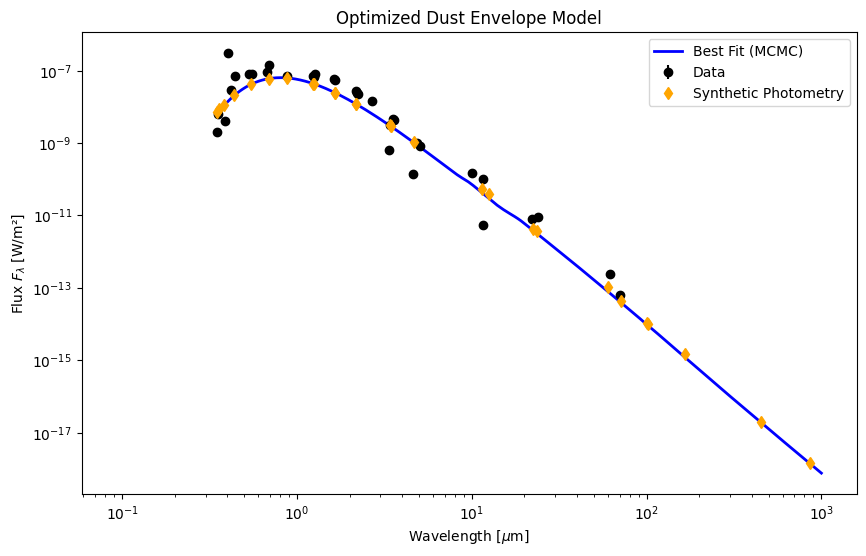

In [8]:
# Plot convergence chains and posterior distributions
analyzer.plot_traces()
analyzer.plot_corner()

# Retrieve the best-fit result (derived from the mean of the posterior chains)
best_result = fitter.best_model

# Final Comparison
fig, ax = plt.subplots()
dataset.plot(ax=ax, label="Data", color='black', marker='o', ls='')
best_result.plot(ax=ax, label="Best Fit (MCMC)", color='blue', lw=2)
plt.title("Optimized Dust Envelope Model")
plt.legend()
plt.show()

**7. Advanced: Real Atmosphere Grids**

Instead of a standard black-body source, you can use high-resolution stellar atmosphere grids (e.g., MARCS).

Loading atmosphere grid from data/marcs_z0.00.fits with wavelength unit: angstrom


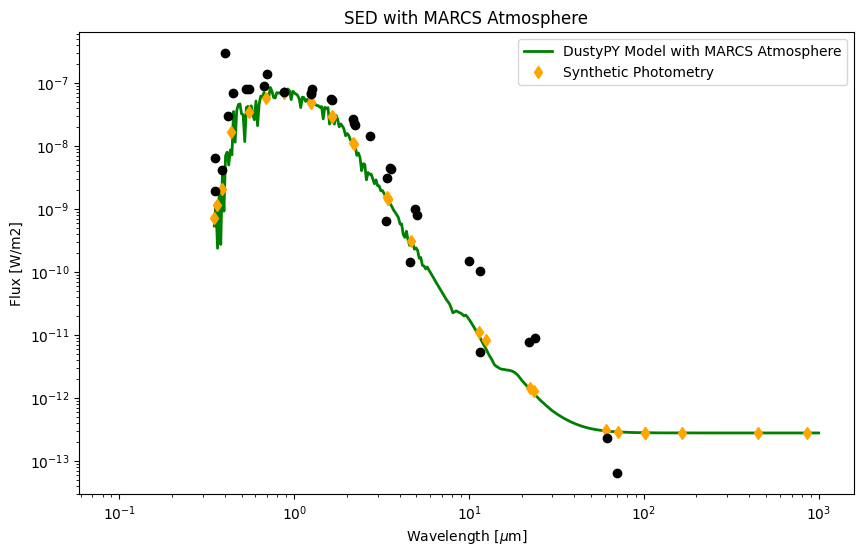

In [9]:
# Enable atmosphere interpolation mode
model.spectral_shape = "atmosphere"
model.grid_path = "data/marcs_z0.00.fits"  # Path to your FITS atmosphere grid (you can dowload from MARCS site, or use the one on zenodo)

# The Runner automatically interpolates Teff and logg from the grid during execution
result_with_atmo = runner.run(model)

# Display the new result with atmosphere interpolation
fig, ax = plt.subplots()
result_with_atmo.plot(ax=ax, label="DustyPY Model with MARCS Atmosphere", color='green', lw=2)
dataset.plot(ax=ax, label="Observations", color='black', marker='o', ls='')
plt.title("SED with MARCS Atmosphere")
plt.show()

**8. Advanced: Photometry**

You can compute synthetic photometry for your model through various filter contain in `result.get_available_filters()` as follow:

['iso_sw11', 'ctio_andicam_k', 'iso_lw3', 'iso_sw1', 'iras_12', 'skymapper_i', 'johnson_i', '2mass_j', 'pacs_70', 'bessell_k', 'iras_100', 'bessell_j', 'johnson_h', 'sdss_z', 'iso_lw2', 'ctio_andicam_j', 'iras_25', 'iso_sw10', 'wise_w1', 'iso_lw5', 'cousins_r', 'iso_sw7', 'skymapper_z', 'gaia3_gbp', 'iso_lw9', 'skymapper_v', 'johnson_v', 'johnson_b', 'iso_lw8', 'iso_lw10', 'sdss_i', 'iso_sw6', 'iso_lw4', 'iso_sw5', 'iso_lw7', 'cousins_i', 'wise_w4', 'iso_sw9', 'iso_sw8', 'skymapper_u', 'sdss_r', 'johnson_u', 'sdss_g', 'iras_60', 'iso_lw6', 'galex_nuv', 'iso_sw4', 'scuba_450', 'johnson_l', 'scuba_850', 'gaia3_grp', 'skymapper_g', 'johnson_r', 'wise_w2', 'sdss_u', 'skymapper_r', 'pacs_160', '2mass_h', 'johnson_k', 'galex_fuv', 'iso_sw3', 'gaia3_g', 'iso_lw1', 'iso_sw2', 'johnson_j', 'bessell_h', 'pacs_100', '2mass_ks', 'wise_w3', 'ctio_andicam_h']
Computing synthetic photometry for: ['gaia3_g', 'gaia3_gbp', 'gaia3_grp']
------------------------------
Filter: gaia3_g
  Pivot Wavelength: 0

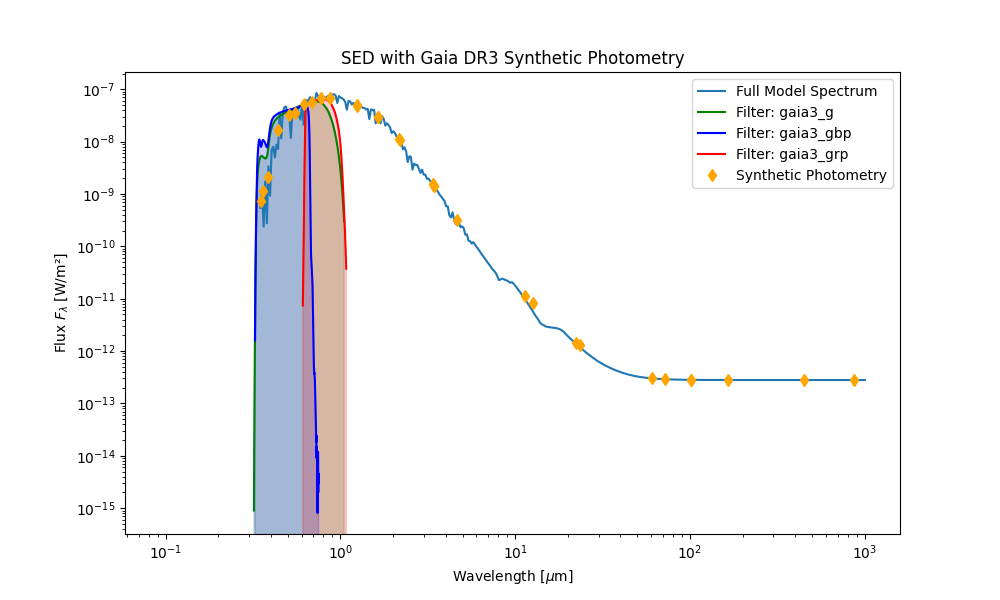

In [10]:
%matplotlib ipympl

print(result_with_atmo.get_available_filters())

# Define the Gaia filter names (matching the .fits files in dustypy/data/filter)
# Available Gaia filters: 'gaia3_g', 'gaia3_gbp', 'gaia3_grp'
gaia_filters = ['gaia3_g', 'gaia3_gbp', 'gaia3_grp']
filter_colors = ['green', 'blue', 'red']

print(f"Computing synthetic photometry for: {gaia_filters}")

# Compute the photometry using the Result object
# This uses the high-performance C integration and filter cache
result_with_atmo.compute_photometry(gaia_filters)

# Access and display the results
print("-" * 30)
for filt_name in gaia_filters:
    if filt_name in result_with_atmo.photometry:
        p = result_with_atmo.photometry[filt_name]
        print(f"Filter: {filt_name}")
        print(f"  Pivot Wavelength: {p['wavelength']:.4f} µm")
        print(f"  Synthetic Flux:   {p['flux']:.3e} W/m²/µm")
        print(f"  Synthetic Flux error:    {p['error']:.3e} W/m²/µm")
        print("-" * 30)

# Plot the SED with the new Gaia synthetic points
ax = result_with_atmo.plot(photometry=True, filters=gaia_filters, filters_colors=filter_colors, label="Full Model Spectrum")
plt.title("SED with Gaia DR3 Synthetic Photometry")
plt.show()

You can also compute the photometry without using dusty to compare a model with and without dust

Filter: gaia3_g
  Pivot Wavelength: 0.6962 µm
  Synthetic Flux:   5.230e-08 W/m²/µm
  Synthetic Flux error:    3.451e-11 W/m²/µm
------------------------------
Filter: gaia3_gbp
  Pivot Wavelength: 0.5568 µm
  Synthetic Flux:   3.273e-08 W/m²/µm
  Synthetic Flux error:    2.624e-11 W/m²/µm
------------------------------
Filter: gaia3_grp
  Pivot Wavelength: 0.7876 µm
  Synthetic Flux:   6.724e-08 W/m²/µm
  Synthetic Flux error:    8.245e-12 W/m²/µm
------------------------------


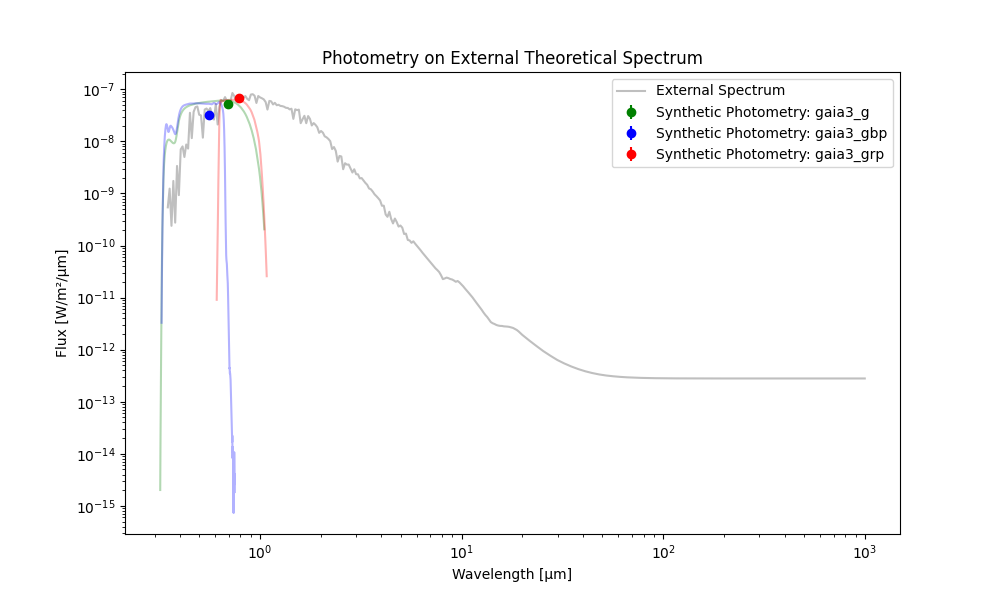

In [11]:
# Define wavelength and flux arrays from the Result
w_ext = result_with_atmo.wavelength
f_ext = result_with_atmo.flux

# Compute synthetic photometry in batch mode
phot = Filter.batch_compute(wavelength=w_ext, flux=f_ext, filter_names=gaia_filters, n_int=5000)
bandpass = Filter.get_bandpass_data(gaia_filters)

# Display the results
for fname, p in phot.items():
	print(f"Filter: {fname}")
	print(f"  Pivot Wavelength: {p['wavelength']:.4f} µm")
	print(f"  Synthetic Flux:   {p['flux']:.3e} W/m²/µm")
	print(f"  Synthetic Flux error:    {p['error']:.3e} W/m²/µm")
	print("-" * 30)

# 4. Visualization

fig, ax = plt.subplots()

ax.loglog(w_ext, f_ext, label="External Spectrum", color='gray', alpha=0.5)
for i, (fname, p) in enumerate(phot.items()):
	ax.errorbar(p['wavelength'], p['flux'], yerr=p['error'], fmt='o', color=filter_colors[i], label=f"Synthetic Photometry: {fname}")
	ax.plot(bandpass[fname]['wavelength'], bandpass[fname]['throughput'] * np.max(f_ext), color=filter_colors[i], alpha=0.3)

ax.set_xlabel("Wavelength [µm]")
ax.set_ylabel("Flux [W/m²/µm]")
ax.legend()
ax.set_title("Photometry on External Theoretical Spectrum")
plt.show()

Finaly, if you need more filter, you can find the ascii file on the website of the spanish SVO [https://svo2.cab.inta-csic.es/theory/fps/] and use this command to add it to the DustyPY library.

In [2]:
ascii_path = "data/LSST_LSST.r.dat" # Path to your ASCII filter file

# Add a custom filter from an ASCII file, specifying detector type (see SVO for the options)
new_filter = Filter.add_custom_filter(ascii_path = ascii_path, filter_name="lsst_r", detector_type='photon')

# On can also change the detector type after creation
new_filter.set_detector_type(filter_name='lsst_r', detector_type='photon')

print(new_filter)


Type de détecteur mis à jour pour lsst_r -> photon (ZP recalculé)
Filter lsst_r successfully added from data/LSST_LSST.r.dat.
Type de détecteur mis à jour pour lsst_r -> photon (ZP recalculé)
Filter name = lsst_r     
detector_type = photon     
pivot_um = 0.6218    
ZP = 2.4534e-08 W/m²/μm           


**Note**: Convention for the filter naming follows VizieR convention `instruments_name_band`.

Exemple: VizieR Jonhson:V --> DustyPY jhonson_v

All filter informations are accessible with this command:

In [4]:
Filter.print_available_filter()


Filtre                    | Type       | Pivot [μm]   | ZP [W/m²/μm]   
-----------------------------------------------------------------------
2mass_h                   | photon     | 1.6495       | 1.1108e-09     
2mass_j                   | photon     | 1.2393       | 3.0557e-09     
2mass_ks                  | photon     | 2.1639       | 4.1782e-10     
bessell_h                 | energy     | 1.6442       | 1.1364e-09     
bessell_j                 | energy     | 1.2348       | 3.1309e-09     
bessell_k                 | energy     | 2.2091       | 3.9258e-10     
cousins_i                 | energy     | 0.7875       | 1.1913e-08     
cousins_r                 | energy     | 0.6473       | 2.2386e-08     
ctio_andicam_H            | energy     | 1.6289       | 1.1747e-09     
ctio_andicam_J            | energy     | 1.2458       | 2.9977e-09     
ctio_andicam_K            | energy     | 2.1410       | 4.3743e-10     
gaia3_g                   | photon     | 0.6218       | 2.5038e